# 🇪🇺 EuroParl Data Exploration
**Project:** English-French Sentiment Analysis (Hands-on NLP)

This notebook covers the **first phase** of the project: Data Loading and Exploration.
We will load the European Parliament proceedings (TMX format), parse the XML structure, and run statistical analysis to understand the quality and characteristics of our dataset before moving on to Sentiment Analysis.

### 1. Imports and Configuration
We start by importing the necessary libraries for XML parsing and file handling. We also define the default paths for our data.
*Note: Make sure your `en-fr.tmx` file is located in a folder named `data` next to this notebook.*

In [56]:
from pathlib import Path
from collections import defaultdict
import re

# 1. Setup Paths
NOTEBOOK_DIR = Path.cwd()
DATA_DIR = NOTEBOOK_DIR / "data"

# Define the specific files you have
EN_PATH = DATA_DIR / "Europarl.en-fr.en"
FR_PATH = DATA_DIR / "Europarl.en-fr.fr"

print(EN_PATH)
print(FR_PATH)

# Verify they exist
if EN_PATH.exists() and FR_PATH.exists():
    print(f"✅ Found English file: {EN_PATH.name}")
    print(f"✅ Found French file:  {FR_PATH.name}")
else:
    print("❌ Error: Files not found. Check your folder structure.")


/content/data/Europarl.en-fr.en
/content/data/Europarl.en-fr.fr
✅ Found English file: Europarl.en-fr.en
✅ Found French file:  Europarl.en-fr.fr


In [60]:
def load_parallel_subset(en_path, fr_path, max_lines=50_000, encoding="cp1252"):
    pairs = []
    try:
        with open(en_path, "r", encoding=encoding, errors="replace") as f_en, \
             open(fr_path, "r", encoding=encoding, errors="replace") as f_fr:
            for i, (line_en, line_fr) in enumerate(zip(f_en, f_fr)):
                if i >= max_lines:
                    break
                text_en = line_en.strip()
                text_fr = line_fr.strip()
                if text_en and text_fr:
                    pairs.append((text_en, text_fr))
    except Exception as e:
        print(f"Error reading files: {e}")
    return pairs

subset_size = 50_000
pairs = load_parallel_subset(EN_PATH, FR_PATH, max_lines=subset_size, encoding="cp1252")
print("loaded:", len(pairs))
print("sample:", pairs[0] if pairs else None)


loaded: 50000
sample: ('recognise that our demands have not been complied with.', "©sion avec l'ensemble des pays candidats.")


### 3. Basic Statistics
This function calculates the mean character and word counts for both English and French sentences. It helps us establish a baseline for the complexity of our text.

In [61]:
def basic_stats(pairs):
    """Print and return basic corpus statistics."""
    if not pairs:
        print("No pairs loaded.")
        return {}

    n = len(pairs)
    en_lens = [len(en) for en, _ in pairs]
    fr_lens = [len(fr) for _, fr in pairs]
    en_words = [len(en.split()) for en, _ in pairs]
    fr_words = [len(fr.split()) for _, fr in pairs]

    stats = {
        "n_pairs": n,
        "en_char_mean": sum(en_lens) / n,
        "fr_char_mean": sum(fr_lens) / n,
        "en_word_mean": sum(en_words) / n,
        "fr_word_mean": sum(fr_words) / n,
        "en_char_min": min(en_lens),
        "en_char_max": max(en_lens),
        "fr_char_min": min(fr_lens),
        "fr_char_max": max(fr_lens),
    }

    print("=== Basic statistics ===")
    print(f"Number of sentence pairs: {n:,}")
    print(f"English — chars: mean={stats['en_char_mean']:.1f}, min={stats['en_char_min']}, max={stats['en_char_max']}")
    print(f"French  — chars: mean={stats['fr_char_mean']:.1f}, min={stats['fr_char_min']}, max={stats['fr_char_max']}")
    print(f"English — words/sent: mean={stats['en_word_mean']:.1f}")
    print(f"French  — words/sent: mean={stats['fr_word_mean']:.1f}")
    return stats

### 4. Length Ratio Analysis
A crucial step for parallel corpora. We compute the ratio of French length to English length.
* **Why?** French text usually expands by about 10-20% compared to English.
* **Outliers:** If the ratio is extremely high or low, it might indicate bad alignment (e.g., a short English sentence aligned with a whole French paragraph).

In [62]:
def length_ratios(pairs, top_k=10):
    """Report length ratios (FR/EN) by character and by word; show extremes."""
    if not pairs:
        return
    ratios_char = []
    ratios_word = []
    for en, fr in pairs:
        l_en = len(en)
        l_fr = len(fr)
        w_en = len(en.split())
        w_fr = len(fr.split())
        if l_en > 0:
            ratios_char.append(l_fr / l_en)
        if w_en > 0:
            ratios_word.append(w_fr / w_en)

    n = len(ratios_char)
    mean_rc = sum(ratios_char) / n
    mean_rw = sum(ratios_word) / n

    print("\n=== Length ratios (FR/EN) ===")
    print(f"By character: mean={mean_rc:.3f}")
    print(f"By word:      mean={mean_rw:.3f}")

    # Pairs with highest/lowest character ratio (skip very short EN to avoid noise)
    min_en_len = 20
    with_ratio = [((en, fr), len(fr) / len(en)) for (en, fr) in pairs if len(en) >= min_en_len]
    with_ratio.sort(key=lambda x: x[1], reverse=True)
    print(f"\nTop {top_k} pairs with highest FR/EN char ratio (EN length >= {min_en_len}):")
    for (en, fr), r in with_ratio[:top_k]:
        print(f"  {r:.2f}  en[{len(en)}] fr[{len(fr)}]  en: {en[:60]}...")
    return {"mean_ratio_char": mean_rc, "mean_ratio_word": mean_rw}

### 5. Sentence Length Distribution
We group sentences into "buckets" based on their length (number of words) to see the distribution.
This helps us decide on parameters like `MAX_SEQ_LENGTH` for our future Transformer models (e.g., if most sentences are < 50 words, we don't need a model that handles 512 tokens).

In [63]:
def sentence_length_distribution(pairs, num_buckets=10):
    """Bucket sentence lengths (by word count) and show distribution."""
    if not pairs:
        return
    en_words = [len(en.split()) for en, _ in pairs]
    fr_words = [len(fr.split()) for _, fr in pairs]
    max_en = max(en_words)
    max_fr = max(fr_words)
    bucket_size_en = max(1, (max_en + num_buckets - 1) // num_buckets)
    bucket_size_fr = max(1, (max_fr + num_buckets - 1) // num_buckets)

    buckets_en = defaultdict(int)
    buckets_fr = defaultdict(int)
    for w in en_words:
        b = min(w // bucket_size_en, num_buckets - 1)
        buckets_en[b] += 1
    for w in fr_words:
        b = min(w // bucket_size_fr, num_buckets - 1)
        buckets_fr[b] += 1

    print("\n=== Sentence length (words) distribution ===")
    print("English (bucket = word count range):")
    for b in sorted(buckets_en.keys()):
        lo = b * bucket_size_en
        hi = (b + 1) * bucket_size_en - 1 if b < num_buckets - 1 else max_en
        print(f"  [{lo:3d}-{hi:3d}]: {buckets_en[b]:,}")
    print("French:")
    for b in sorted(buckets_fr.keys()):
        lo = b * bucket_size_fr
        hi = (b + 1) * bucket_size_fr - 1 if b < num_buckets - 1 else max_fr
        print(f"  [{lo:3d}-{hi:3d}]: {buckets_fr[b]:,}")

### 6. Data Sampling
It is essential to look at the actual text to verify quality. This function prints a few random (or equidistant) pairs from the loaded subset.

In [64]:
def sample_pairs(pairs, k=5, indices=None):
    """Print k sample pairs (or at given indices)."""
    if not pairs:
        return
    n = len(pairs)
    if indices is None:
        step = max(1, n // (k + 1))
        indices = [i * step for i in range(k)]
    print("\n=== Sample pairs ===")
    for i, idx in enumerate(indices):
        if idx >= n:
            break
        en, fr = pairs[idx]
        print(f"--- Pair {i+1} (index {idx}) ---")
        print(f"EN: {en[:200]}{'...' if len(en) > 200 else ''}")
        print(f"FR: {fr[:200]}{'...' if len(fr) > 200 else ''}")
        print()

### 7. Vocabulary Trends
A simple frequency analysis to find the most common words in the loaded subset. This acts as a sanity check (e.g., seeing "the" and "le" as top words confirms the language identification is likely correct).

In [65]:
def vocabulary_trends(pairs, top_n=20):
    """Simple word frequency (EN and FR) on the subset."""
    if not pairs:
        return
    en_freq = defaultdict(int)
    fr_freq = defaultdict(int)
    word_re = re.compile(r"\b\w+\b", re.UNICODE)

    for en, fr in pairs:
        for m in word_re.finditer(en.lower()):
            en_freq[m.group()] += 1
        for m in word_re.finditer(fr.lower()):
            fr_freq[m.group()] += 1

    en_top = sorted(en_freq.items(), key=lambda x: -x[1])[:top_n]
    fr_top = sorted(fr_freq.items(), key=lambda x: -x[1])[:top_n]

    print("\n=== Top words (subset) ===")
    print("English:", [w for w, _ in en_top])
    print("French: ", [w for w, _ in fr_top])
    return {"en_top": en_top, "fr_top": fr_top}

In [66]:
# Configuration for the run
subset_size = 50_000
num_samples = 5
num_buckets = 10
top_words = 25

print(f"Loading up to {subset_size:,} pairs from parallel files...")

# --- THIS IS THE KEY CHANGE ---
# Old: pairs = load_tmx_subset_robust(TMX_PATH, max_tu=subset_size)
# New:
pairs = load_parallel_subset(EN_PATH, FR_PATH, max_lines=subset_size)
# ------------------------------

print(f"Loaded {len(pairs):,} pairs.\n")

if pairs:
    basic_stats(pairs)
    length_ratios(pairs, top_k=5)
    sentence_length_distribution(pairs, num_buckets=num_buckets)
    vocabulary_trends(pairs, top_n=top_words)
    sample_pairs(pairs, k=num_samples)
else:
    print("No data found. Please check EN_PATH and FR_PATH.")

Loading up to 50,000 pairs from parallel files...
Loaded 50,000 pairs.

=== Basic statistics ===
Number of sentence pairs: 50,000
English — chars: mean=149.5, min=1, max=1146
French  — chars: mean=171.5, min=1, max=1460
English — words/sent: mean=25.2
French  — words/sent: mean=26.7

=== Length ratios (FR/EN) ===
By character: mean=1.861
By word:      mean=1.665

Top 5 pairs with highest FR/EN char ratio (EN length >= 20):
  29.05  en[20] fr[581]  en: Then he should come....
  28.61  en[23] fr[658]  en: I saw no disadvantages....
  25.52  en[23] fr[587]  en: Are there any comments?...
  25.00  en[21] fr[525]  en: Thank you Mr Fatuzzo....
  24.76  en[21] fr[520]  en: The debate is closed....

=== Sentence length (words) distribution ===
English (bucket = word count range):
  [  0- 17]: 17,637
  [ 18- 35]: 22,019
  [ 36- 53]: 7,702
  [ 54- 71]: 1,958
  [ 72- 89]: 514
  [ 90-107]: 132
  [108-125]: 24
  [126-143]: 10
  [144-161]: 2
  [162-178]: 2
French:
  [  0- 22]: 23,455
  [ 23- 45]: 20

In [67]:
import matplotlib.pyplot as plt
import numpy as np

# Make figures look nice and large
plt.style.use('ggplot')  # Use a clean style similar to R's ggplot
plt.rcParams['figure.figsize'] = (12, 6)

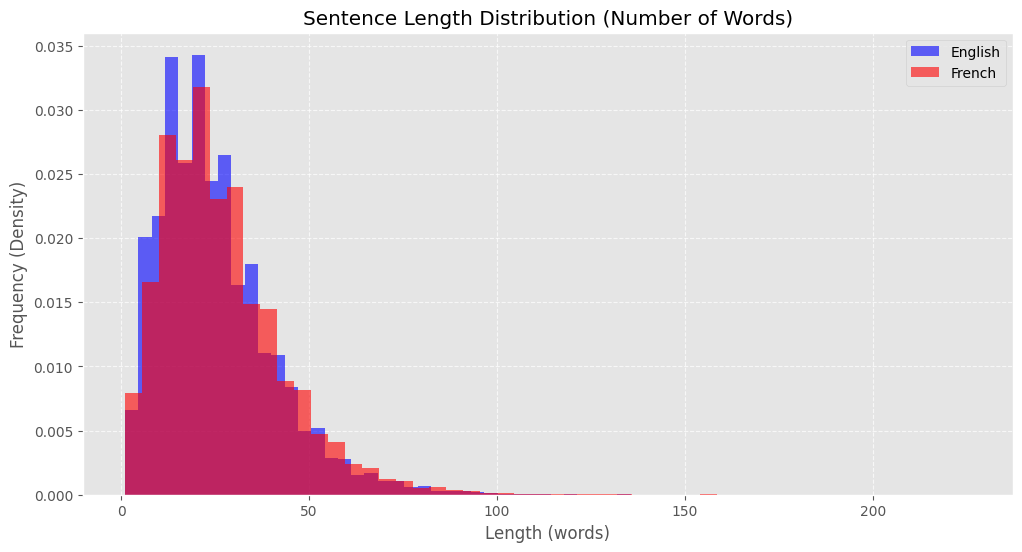

In [68]:
def plot_sentence_length_distribution(pairs, bins=50):
    """
    Plots the distribution of sentence lengths (in words) for both languages.
    """
    if not pairs:
        print("No data to plot.")
        return

    # Calculate lengths (word count)
    en_lens = [len(en.split()) for en, _ in pairs]
    fr_lens = [len(fr.split()) for _, fr in pairs]

    # Create the plot
    plt.figure(figsize=(12, 6))

    # English Histogram
    plt.hist(en_lens, bins=bins, alpha=0.6, label='English', color='blue', density=True)

    # French Histogram
    plt.hist(fr_lens, bins=bins, alpha=0.6, label='French', color='red', density=True)

    plt.title('Sentence Length Distribution (Number of Words)')
    plt.xlabel('Length (words)')
    plt.ylabel('Frequency (Density)')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

# Run it
plot_sentence_length_distribution(pairs)

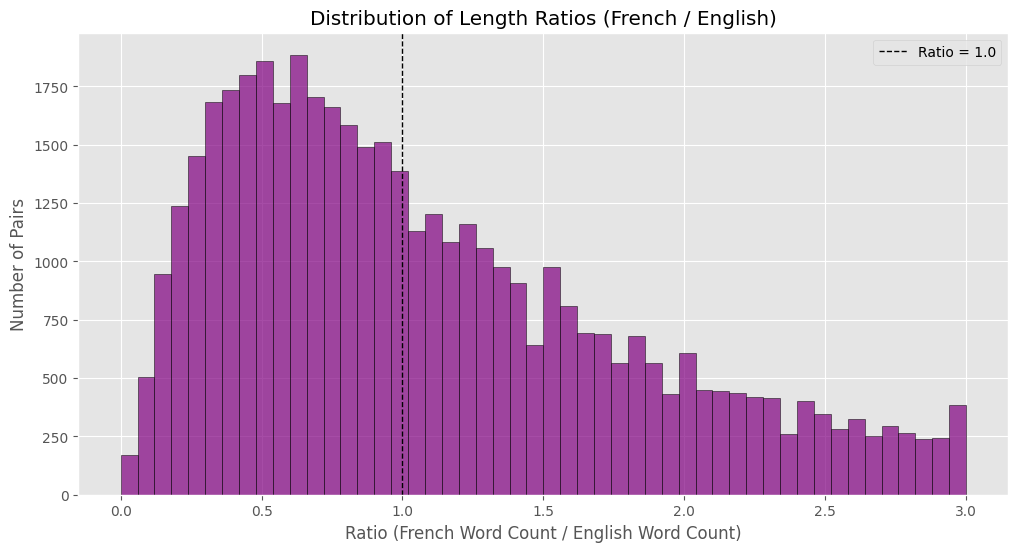

In [69]:
def plot_length_ratios(pairs, bins=50):
    """
    Plots the histogram of the ratio (French Length / English Length).
    """
    if not pairs: return

    ratios = []
    for en, fr in pairs:
        len_en = len(en.split())
        len_fr = len(fr.split())
        if len_en > 0:
            ratios.append(len_fr / len_en)

    plt.figure(figsize=(12, 6))
    plt.hist(ratios, bins=bins, range=(0, 3), color='purple', edgecolor='black', alpha=0.7)

    # Add a vertical line at 1.0 (perfect length match)
    plt.axvline(1.0, color='black', linestyle='dashed', linewidth=1, label='Ratio = 1.0')

    plt.title('Distribution of Length Ratios (French / English)')
    plt.xlabel('Ratio (French Word Count / English Word Count)')
    plt.ylabel('Number of Pairs')
    plt.legend()
    plt.show()

# Run it
plot_length_ratios(pairs)

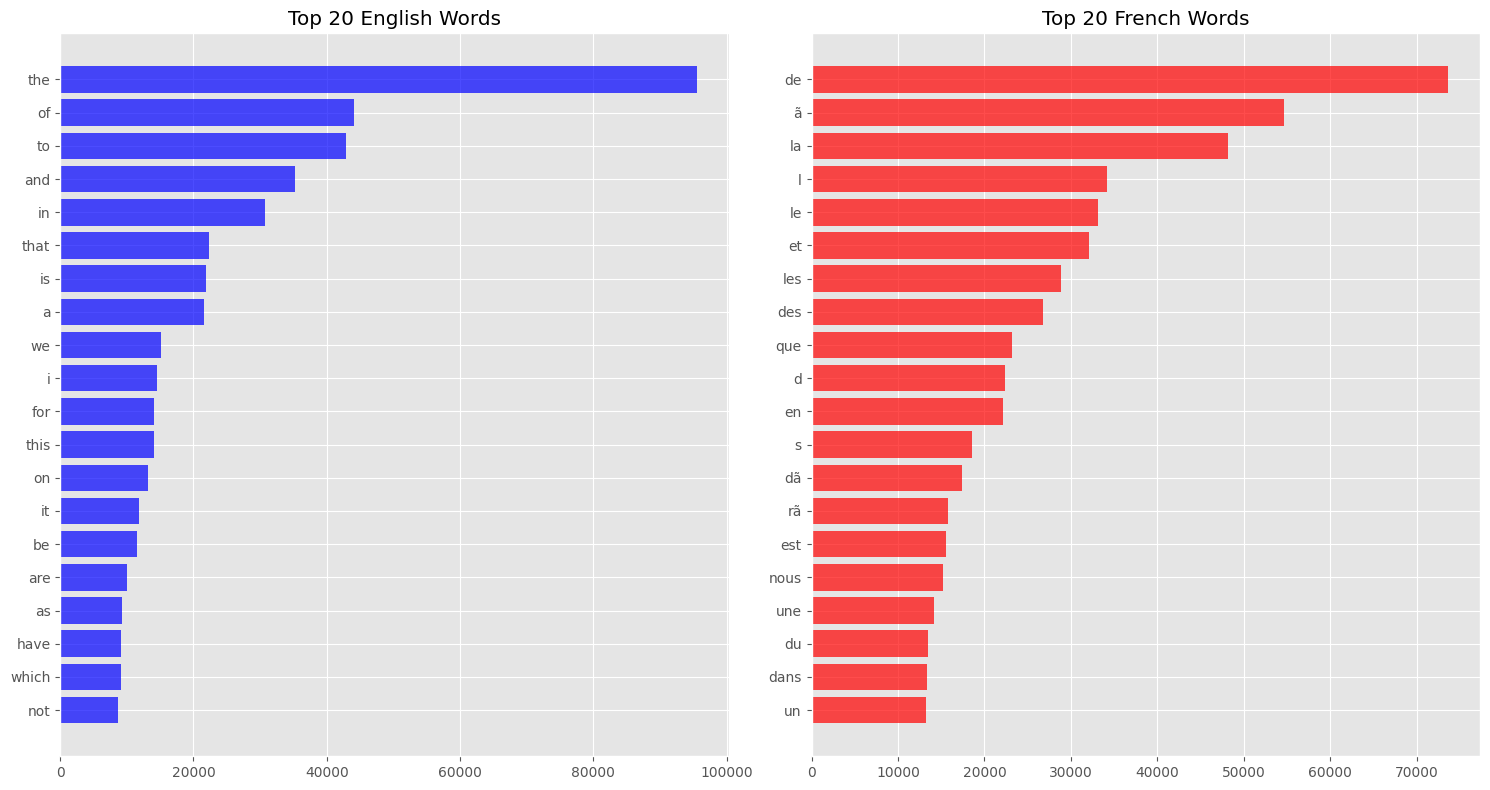

In [70]:
def plot_top_words(pairs, top_n=20):
    """
    Plots a horizontal bar chart of the most frequent words in both languages.
    """
    from collections import Counter
    import re

    # Tokenizer regex (simple version)
    word_re = re.compile(r"\b\w+\b", re.UNICODE)

    # Count words
    en_counts = Counter()
    fr_counts = Counter()

    for en, fr in pairs:
        # Update counts (lowercase to merge The/the)
        en_counts.update(word_re.findall(en.lower()))
        fr_counts.update(word_re.findall(fr.lower()))

    # Get top N
    en_top = en_counts.most_common(top_n)
    fr_top = fr_counts.most_common(top_n)

    # Plotting
    fig, axes = plt.subplots(1, 2, figsize=(15, 8))

    # English Plot
    words, counts = zip(*reversed(en_top)) # Reverse for horizontal bar chart
    axes[0].barh(words, counts, color='blue', alpha=0.7)
    axes[0].set_title(f'Top {top_n} English Words')

    # French Plot
    words, counts = zip(*reversed(fr_top))
    axes[1].barh(words, counts, color='red', alpha=0.7)
    axes[1].set_title(f'Top {top_n} French Words')

    plt.tight_layout()
    plt.show()

# Run it
plot_top_words(pairs)

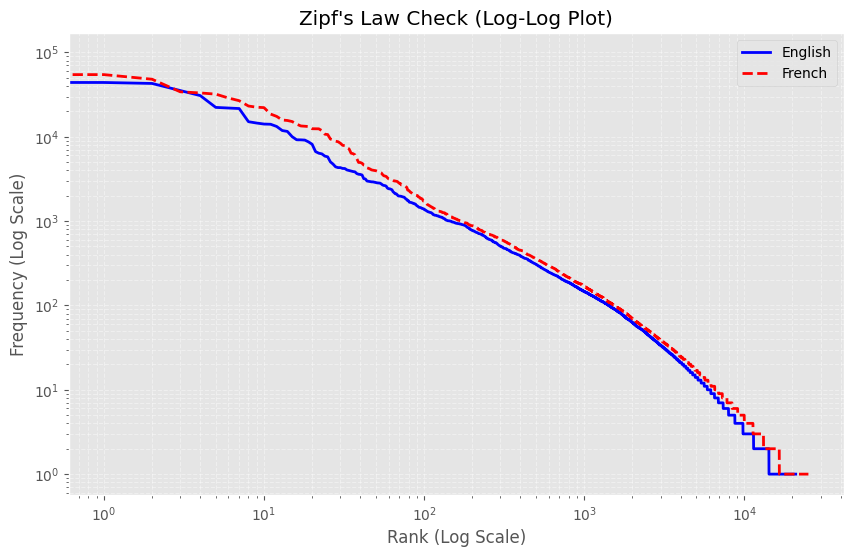

In [71]:
def plot_zipf_law(pairs):
    """
    Plots the word frequency distribution on a log-log scale to check Zipf's Law.
    """
    import matplotlib.pyplot as plt
    from collections import Counter
    import re

    if not pairs: return

    # Tokenizer
    word_re = re.compile(r"\b\w+\b", re.UNICODE)

    # Count words
    en_counts = Counter()
    fr_counts = Counter()

    for en, fr in pairs:
        en_counts.update(word_re.findall(en.lower()))
        fr_counts.update(word_re.findall(fr.lower()))

    # Get frequencies sorted by rank
    en_freqs = sorted(en_counts.values(), reverse=True)
    fr_freqs = sorted(fr_counts.values(), reverse=True)

    # Plot
    plt.figure(figsize=(10, 6))
    plt.loglog(en_freqs, label='English', color='blue', linewidth=2)
    plt.loglog(fr_freqs, label='French', color='red', linestyle='--', linewidth=2)

    plt.title("Zipf's Law Check (Log-Log Plot)")
    plt.xlabel("Rank (Log Scale)")
    plt.ylabel("Frequency (Log Scale)")
    plt.legend()
    plt.grid(True, which="both", ls="--", alpha=0.4)
    plt.show()

plot_zipf_law(pairs)

In [72]:
import nltk

# Download necessary NLTK data (run once)
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab') # Sometimes needed for newer NLTK versions

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

Tokenizing and counting... (this may take a moment)


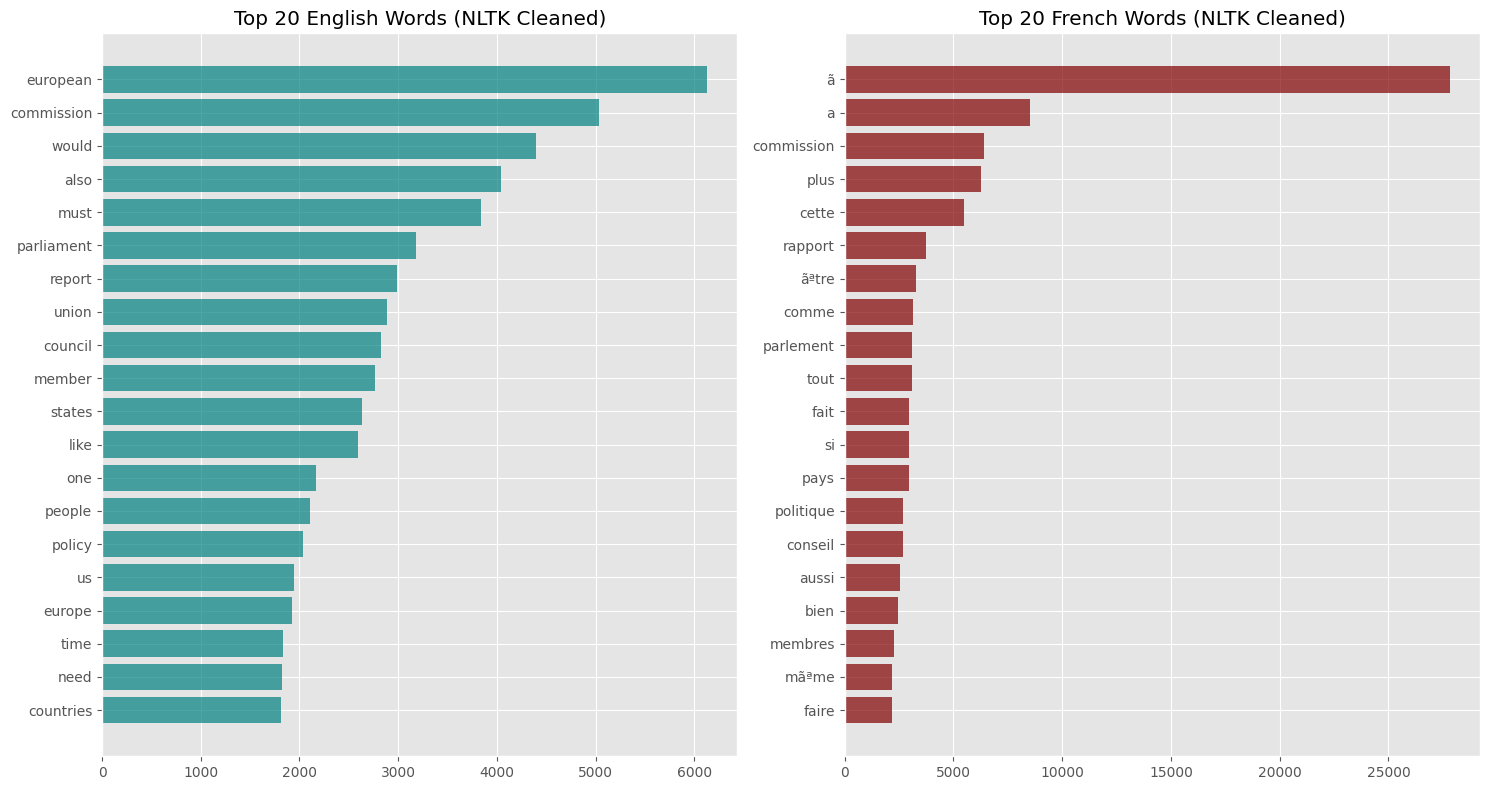

In [73]:
def plot_top_words_nltk(pairs, top_n=20):
    """
    Plots the most frequent words using NLTK for tokenization and stopword removal.
    """
    import matplotlib.pyplot as plt
    from collections import Counter
    from nltk.corpus import stopwords
    from nltk.tokenize import word_tokenize
    import string

    # 1. Load NLTK Resources
    stop_words_en = set(stopwords.words('english'))
    stop_words_fr = set(stopwords.words('french'))

    # Add domain-specific noise to the stoplist (Europarl specific)
    custom_stops = {'mr', 'madam', 'president', 'monsieur', 'madame', 'président', "n't", "'s"}
    stop_words_en.update(custom_stops)
    stop_words_fr.update(custom_stops)

    en_counts = Counter()
    fr_counts = Counter()

    print("Tokenizing and counting... (this may take a moment)")

    # 2. Process Data
    for en, fr in pairs:
        # --- English Processing ---
        # Tokenize
        tokens_en = word_tokenize(en.lower())
        # Filter: strictly alphabetic AND not in stop words
        clean_en = [t for t in tokens_en if t.isalpha() and t not in stop_words_en]
        en_counts.update(clean_en)

        # --- French Processing ---
        tokens_fr = word_tokenize(fr.lower())
        clean_fr = [t for t in tokens_fr if t.isalpha() and t not in stop_words_fr]
        fr_counts.update(clean_fr)

    # 3. Plotting (Same logic as before)
    en_top = en_counts.most_common(top_n)
    fr_top = fr_counts.most_common(top_n)

    fig, axes = plt.subplots(1, 2, figsize=(15, 8))

    # English
    if en_top:
        words, counts = zip(*reversed(en_top))
        axes[0].barh(words, counts, color='teal', alpha=0.7)
    axes[0].set_title(f'Top {top_n} English Words (NLTK Cleaned)')

    # French
    if fr_top:
        words, counts = zip(*reversed(fr_top))
        axes[1].barh(words, counts, color='maroon', alpha=0.7)
    axes[1].set_title(f'Top {top_n} French Words (NLTK Cleaned)')

    plt.tight_layout()
    plt.show()

# Run it
plot_top_words_nltk(pairs)

## Data Preparation

In [74]:
import random

# 1. Shuffle and Split
def split_data(pairs, test_ratio=0.1):
    # Shuffle to ensure random distribution
    random.seed(42)
    random.shuffle(pairs)

    split_idx = int(len(pairs) * (1 - test_ratio))
    train_pairs = pairs[:split_idx]
    test_pairs = pairs[split_idx:]

    return train_pairs, test_pairs

# Run split
train_pairs, test_pairs = split_data(pairs)

print(f"Training Set: {len(train_pairs):,} pairs")
print(f"Test Set:     {len(test_pairs):,} pairs")

Training Set: 45,000 pairs
Test Set:     5,000 pairs


## Baseline Model (Statistical Dictionary)


This satisfies the "Simple / Lexicon-based" requirement. It builds a dictionary by looking at which French words appear most often in the same sentences as English words.

In [75]:
from collections import defaultdict, Counter
import re
from nltk.tokenize import word_tokenize

class DictionaryTranslator:
    def __init__(self):
        self.dictionary = {}

    def fit(self, pairs):
        """
        Builds a simple dictionary based on word co-occurrence.
        (Note: This is a naive heuristic for a baseline)
        """
        print("Training Baseline Dictionary... (this might take a minute)")
        co_occurrence = defaultdict(Counter)

        # Count which French words appear with which English words
        for en, fr in pairs:
            # Simple tokenization
            en_tokens = [w.lower() for w in word_tokenize(en) if w.isalnum()]
            fr_tokens = [w.lower() for w in word_tokenize(fr) if w.isalnum()]

            for ew in en_tokens:
                for fw in fr_tokens:
                    co_occurrence[ew][fw] += 1

        # Select the most frequent translation for each English word
        self.dictionary = {}
        for en_word, counts in co_occurrence.items():
            # Get the single most common co-occurring French word
            best_match = counts.most_common(1)[0][0]
            self.dictionary[en_word] = best_match

        print(f"Dictionary built with {len(self.dictionary)} words.")

    def translate(self, text):
        """
        Translates text word-for-word using the learned dictionary.
        """
        tokens = [w.lower() for w in word_tokenize(text)]
        translated = []
        for t in tokens:
            # Use dictionary if found, otherwise keep original
            trans = self.dictionary.get(t, f"<{t}>")
            translated.append(trans)
        return " ".join(translated)

In [76]:
# --- RUN BASELINE ---
baseline_model = DictionaryTranslator()
baseline_model.fit(train_pairs[:5000]) # Train on a subset for speed

# Test it
print("\n--- Baseline Results ---")
for en, fr in test_pairs[:3]:
    pred = baseline_model.translate(en)
    print(f"Input:  {en}")
    print(f"Ref:    {fr}")
    print(f"Pred:   {pred}\n")

Training Baseline Dictionary... (this might take a minute)
Dictionary built with 8545 words.

--- Baseline Results ---
Input:  The vote will take place tomorrow at 11 a.m.
Ref:    Pour cela, nous devons adapter Ã  prÃ©sent le statut au rÃ¨glement financier en proposant la suppression de deux articles - l'article 12Âº et l'article 16Âº de la dÃ©cision du Parlement de 1994 - approuvant, comme chacun sait, le statut et les conditions gÃ©nÃ©rales de l'exercice des fonctions de mÃ©diateur europÃ©en.
Pred:   de de de de de de de de <a.m> <.>

Input:  I cannot therefore vote in favour of the Council' s common position.
Ref:    Si je me rÃ©jouis d'une coopÃ©ration plus Ã©troite entre les services de police des Ã‰tats membres, aussi bien entre eux que par l'intermÃ©diaire d'Europol, je partage les prÃ©occupations du rapporteur concernant le manque de responsabilitÃ© dÃ©mocratique d'Europol.
Pred:   de de de de de de de de de de <'> de de de <.>

Input:  It is therefore up to the judges in the C

## Evaluation Function (BLEU Score)
In Translation, we don't use Accuracy; we use BLEU. This metric checks how much overlap there is between your prediction and the reference.

In [84]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

def evaluate_model(model, test_set, num_samples=100):
    scores = []
    smooth = SmoothingFunction().method1

    # Evaluate on a random sample to save time
    sample = test_set[:num_samples]

    for en, fr in sample:
        # Get prediction
        # Handle both our Class-based baseline and future HuggingFace models
        if hasattr(model, 'translate'):
            pred_str = model.translate(en)
        else:
            # Placeholder for transformer logic later
            pred_str = ""

        # Calculate BLEU (needs list of tokens)
        ref_tokens = word_tokenize(fr.lower())
        pred_tokens = word_tokenize(pred_str.lower())

        score = sentence_bleu([ref_tokens], pred_tokens, smoothing_function=smooth)
        scores.append(score)

    avg_score = sum(scores) / len(scores)
    print(f"Average BLEU Score: {avg_score:.4f}")
    return avg_score

In [85]:
# Evaluate Baseline
print("Evaluating Baseline Model...")
evaluate_model(baseline_model, test_pairs)

Evaluating Baseline Model...
Average BLEU Score: 0.0067


0.006722637964186182

## Advanced Model (Fine-Tuning a Transformer)

In [86]:
# Install libraries if you haven't yet
# !pip install transformers datasets sacremoses accelerate

from transformers import MarianMTModel, MarianTokenizer, Seq2SeqTrainingArguments, Seq2SeqTrainer, DataCollatorForSeq2Seq
from datasets import Dataset

# 1. Setup Model Name (Helsinki-NLP is standard for Opus-MT)
model_name = "Helsinki-NLP/opus-mt-en-fr"

# 2. Load Tokenizer & Model
tokenizer = MarianTokenizer.from_pretrained(model_name)
model = MarianMTModel.from_pretrained(model_name)

Loading weights:   0%|          | 0/258 [00:00<?, ?it/s]

The tied weights mapping and config for this model specifies to tie model.shared.weight to model.decoder.embed_tokens.weight, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning
The tied weights mapping and config for this model specifies to tie model.shared.weight to model.encoder.embed_tokens.weight, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning


In [87]:
# 3. Prepare Data for Hugging Face
# We convert our list of tuples into a HF Dataset dictionary
def format_data(pairs):
    return {"translation": [{"en": en, "fr": fr} for en, fr in pairs]}

train_ds = Dataset.from_dict(format_data(train_pairs[:2000])) # Small subset for demo speed
test_ds = Dataset.from_dict(format_data(test_pairs[:100]))

In [112]:
def preprocess_function(batch):
    inputs  = [x["en"] for x in batch["translation"]]
    targets = [x["fr"] for x in batch["translation"]]

    model_inputs = tokenizer(
        inputs,
        truncation=True,
        max_length=128,
        padding="max_length",
    )

    labels = tokenizer(
        text_target=targets,
        truncation=True,
        max_length=128,
        padding="max_length",
    )

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

tokenized_train = train_ds.map(preprocess_function, batched=True, remove_columns=train_ds.column_names)
tokenized_test  = test_ds.map(preprocess_function, batched=True, remove_columns=test_ds.column_names)

print(tokenized_train.column_names)


Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

['input_ids', 'attention_mask', 'labels']


In [113]:
tokenized_train = train_ds.map(preprocess_function, batched=True)
tokenized_test = test_ds.map(preprocess_function, batched=True)

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

In [114]:
# 5. Training Arguments

from transformers import Seq2SeqTrainer, DataCollatorForSeq2Seq

args = Seq2SeqTrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",

    learning_rate=2e-5,
    per_device_train_batch_size=4,  # Low batch size for CPU/Colab
    per_device_eval_batch_size=4,
    weight_decay=0.01,
    save_total_limit=1,
    num_train_epochs=1,            # 1 epoch is enough for a demo
    predict_with_generate=True,
    logging_steps=50,
)

# 6. Initialize Trainer
args = Seq2SeqTrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    weight_decay=0.01,
    save_total_limit=1,
    num_train_epochs=1,
    predict_with_generate=True,
    logging_steps=50,
)

trainer = Seq2SeqTrainer(
    model=model,
    args=args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,

    data_collator=DataCollatorForSeq2Seq(tokenizer, model=model),
)


print("Starting Training... (This uses Embeddings & Attention!)")
trainer.train()

Starting Training... (This uses Embeddings & Attention!)


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 